# Imports

In [ ]:
!pip install graphviz==0.9
!pip install pydot
!pip install seaborn==0.9.0
!apt-get install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [ ]:
x = dados[['preco','idade_do_modelo','km_por_ano']]
y = dados['vendido']

# Cross validate

In [ ]:
# Usando o DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

modelo = DummyClassifier()
results = cross_validate(modelo, x, y, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100,
                                                            (media + 2 * desvio_padrao)*100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, 
                                                            (media + 2 * desvio_padrao)*100))

Accuracy com cross validation, 10 = [74.24, 77.32]


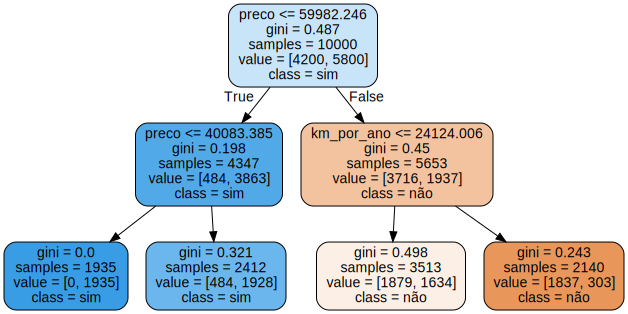

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x, y)
features = x.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

# GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold

espaco_de_parametros = {"max_depth" : [3, 5],
                        "min_samples_split" : [32, 64, 128],
                        "min_samples_leaf" : [32, 64, 128],
                        "criterion" : ["gini", "entropy"]}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = StratifiedKFold(n_splits = 10))
busca.fit(x, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 5],
                         'min_samples_leaf': [32, 64, 128],
                         'min_samples_split': [32, 64, 128]})

In [ ]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.69000000000001


In [ ]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [ ]:
from sklearn.metrics import accuracy_score

predicoes = melhor.predict(x)
accuracy = accuracy_score(predicoes, y) * 100
print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


# Nested Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x, y, cv = StratifiedKFold(n_splits=5, shuffle=True))
scores

array([0.7865, 0.7765, 0.794 , 0.7825, 0.792 ])

In [ ]:
media = scores.mean() * 100
desvio = scores.std() * 100
print("Accuracy médio %.2f" % media)
print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Accuracy médio 78.63
Intervalo [77.36, 79.90]


In [ ]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


### Arvore

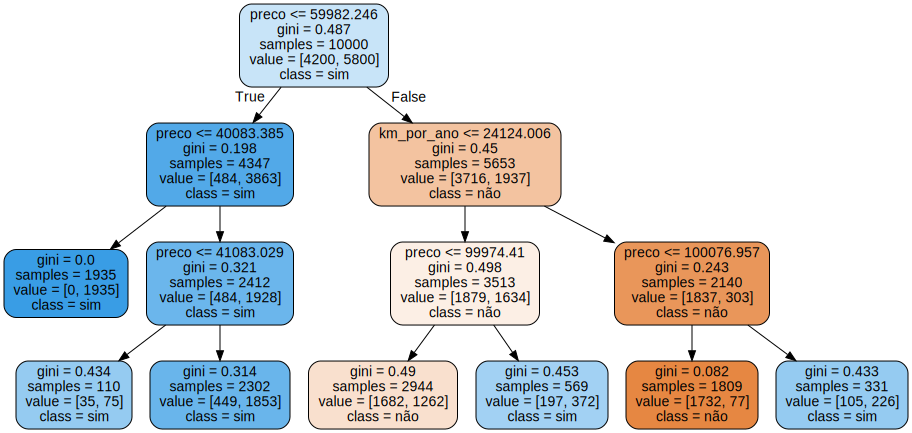

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

features = x.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

# RandomSearch

## Explorando em 16 pontos do espaço

In [ ]:
# Explorando o espaco de parametros com n_iter = 16.
from sklearn.model_selection import RandomizedSearchCV 

espaco_de_parametros = {"max_depth" : [3, 5],
                        "min_samples_split" : [32, 64, 128],
                        "min_samples_leaf" : [32, 64, 128],
                        "criterion" : ["gini", "entropy"]}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 16, 
                    cv = StratifiedKFold(n_splits = 5, shuffle=True))
busca.fit(x,y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=16,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5],
                                        'min_samples_leaf': [32, 64, 128],
                                        'min_samples_split': [32, 64, 128]})

In [ ]:
scores = cross_val_score(busca, x, y, cv = StratifiedKFold(n_splits=5, shuffle=True)) 

media = scores.mean() * 100
desvio = scores.std() * 100
print("Accuracy médio %.2f" % media)

print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Accuracy médio 78.56
Intervalo [77.42, 79.70]


In [ ]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=32, min_samples_split=32)


### Arvore

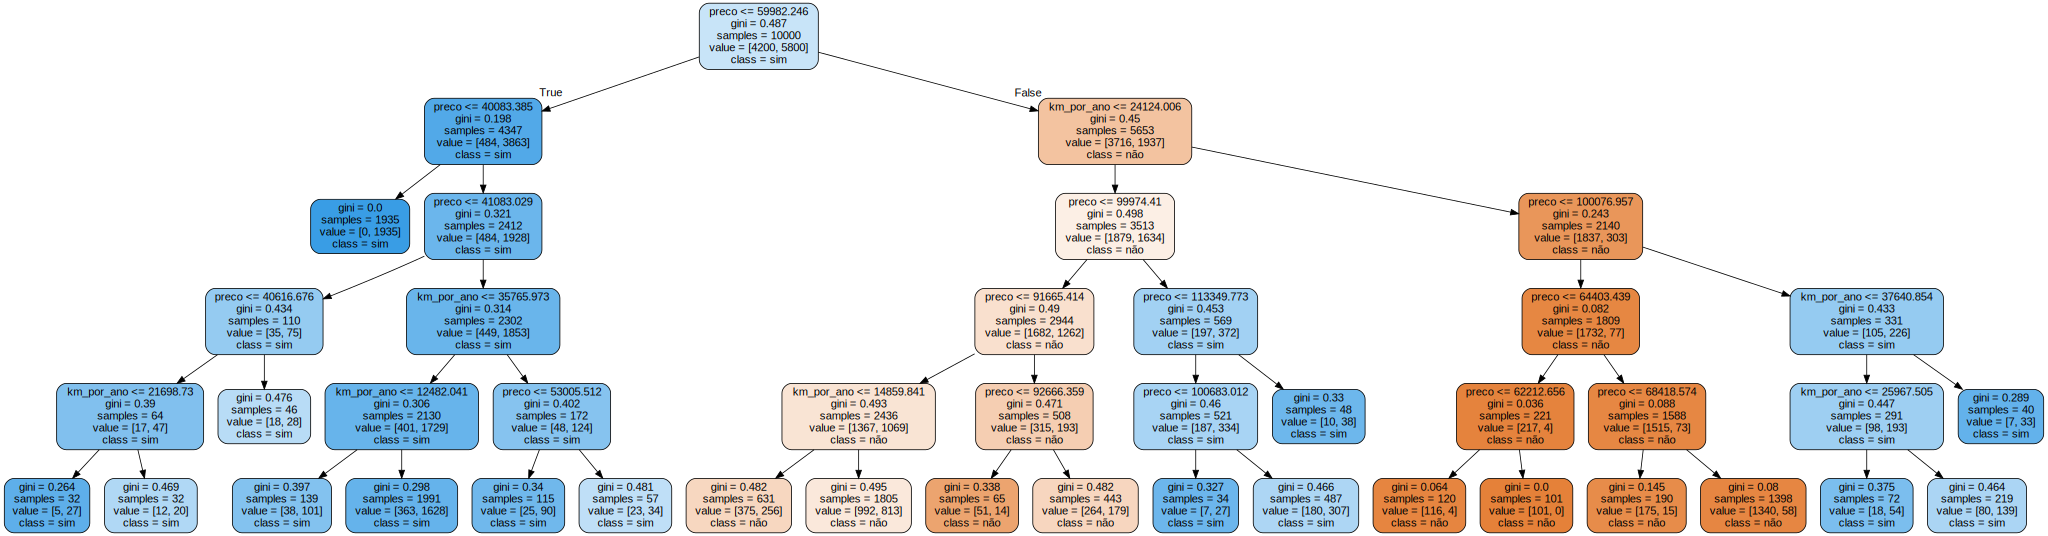

In [ ]:
features = x.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

## Explorando por espaços maiores.

In [ ]:
from scipy.stats import randint 

espaco_de_parametros = {"max_depth" : [3, 5, 10, 15, 20, 30, None],
                        "min_samples_split" : randint(32, 128),
                        "min_samples_leaf" : randint(32, 128),
                        "criterion" : ["gini", "entropy"]}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 64,
                    cv = StratifiedKFold(n_splits = 5, shuffle=True))
busca.fit(x, y)

In [ ]:
resultados = pd.DataFrame(busca.cv_results_)
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.016) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 37, 'min_samples_split': 112}
0.787 +-(0.016) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 75, 'min_samples_split': 98}
0.787 +-(0.016) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 81, 'min_samples_split': 127}
0.787 +-(0.016) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 77, 'min_samples_split': 115}
0.787 +-(0.016) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 98, 'min_samples_split': 62}
0.787 +-(0.016) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 98, 'min_samples_split': 60}
0.787 +-(0.016) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 79, 'min_samples_split': 72}
0.787 +-(0.016) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 124, 'min_samples_split': 94}
0.787 +-(0.016) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 93, 'min_samples_split': 41}
0.787 +-(0.016) {'criterion': 'entropy', 'max_depth': 3, 

In [ ]:
scores = cross_val_score(busca, x, y, cv = StratifiedKFold(n_splits=5, shuffle=True))
media = scores.mean() * 100
desvio = scores.std() * 100
print("Accuracy médio %.2f" % media)
print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Accuracy médio 78.67
Intervalo [76.78, 80.56]


In [ ]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=65,
                       min_samples_split=91)
